# Lab 02 : Vanilla GAN with MLP - solution

The goal is to implement a GAN architecture with MLPs to generate new MNIST images.</br>

In [2]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS4243_codes/codes/labs_lecture15/lab02_GAN_MLP'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/GAN/new_codes/labs_lecture15/
/content/gdrive/My Drive/GAN/new_codes/labs_lecture15


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import utils
import time

### GPU is required to train GAN

In [4]:
device= torch.device("cuda")
#device= torch.device("cpu")
print(device)

cuda


In [5]:
# Libraries
import matplotlib.pyplot as plt
import logging
logging.getLogger().setLevel(logging.CRITICAL) # remove warnings

### MNIST dataset 

In [6]:
from utils import check_mnist_dataset_exists
data_path=check_mnist_dataset_exists()

train_data=torch.load(data_path+'mnist/train_data.pt')
train_label=torch.load(data_path+'mnist/train_label.pt')
print(train_data.size())

torch.Size([60000, 28, 28])


### Network architecture

In [7]:
# Global constants
# n : nb of pixels along each spatial dimension
# dz : latent dimension
# d : hidden dimension
# b : batch size
n = train_data.size(1)
dz = n
d = 32* (n//4)**2 # hidden dimension is a function of image size
b = 64


In [8]:
# Define the generator and discriminator networks
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        # COMPLETE HERE
        self.linear1 = nn.Linear(dz, d, bias=True) 
        self.bn1 = nn.BatchNorm1d(d)
        self.linear2 = nn.Linear(d, d, bias=True) 
        self.bn2 = nn.BatchNorm1d(d)
        self.linear3 = nn.Linear(d, n**2, bias=True)
    def forward(self, z): 
        # COMPLETE HERE
        h = self.linear1(z) # [b, d]
        h = self.bn1(h)
        h = torch.relu(h)
        h = self.linear2(h) # [b, d]
        h = self.bn2(h)
        h = torch.relu(h)
        h = self.linear3(h) # [b, n**2]
        h = h.view(-1, 1, n, n) # [b, 1, n, n], nb colors = 1
        #g_z = torch.tanh(h) # in general [-1,1]
        g_z = torch.sigmoid(h) # for mnist [0,1]
        return g_z

class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        # COMPLETE HERE
        self.linear1 = nn.Linear(n**2, d, bias=True)
        self.bn1 = nn.BatchNorm1d(d)
        self.linear2 = nn.Linear(d, d, bias=True)
        self.bn2 = nn.BatchNorm1d(d)
        self.linear3 = nn.Linear(d, 1, bias=True)
    def forward(self, h): 
        # COMPLETE HERE
        h = h.view(-1, n**2) # [b, n**2]
        h = self.linear1(h) # [b, d]
        h = self.bn1(h)
        h = torch.relu(h)
        h = self.linear2(h) # [b, d]
        h = self.bn2(h)
        h = torch.relu(h)
        h = self.linear3(h) # [b, 1], nb colors = 1
        d_h = torch.sigmoid(h)
        return d_h

# Instantiate the network
net_g = generator()
net_g = net_g.to(device)
print(net_g)
utils.display_num_param(net_g) 
net_d = discriminator()
net_d = net_d.to(device)
print(net_d)
utils.display_num_param(net_d) 

# Test the forward pass, backward pass and gradient update with a single batch
init_lr = 0.001
optimizer_g = torch.optim.Adam(net_g.parameters(), lr=init_lr)
optimizer_d = torch.optim.Adam(net_d.parameters(), lr=init_lr)

b = 10
idx = torch.LongTensor(b).random_(0,60000)
x = train_data[idx,:,:].view(b,-1) # [b, n**2]
x = x.to(device)
print(x.size())

z = torch.rand(b, dz) # [b, dz]
label_real = torch.ones(b, 1)
label_fake = torch.zeros(b, 1)
z = z.to(device)
label_real = label_real.to(device)
label_fake = label_fake.to(device)

# update g
optimizer_g.zero_grad()
g_z = net_g(z) # [b, 1, n, n]
g_fake = net_d(g_z) # [b, 1]
print(g_z.size())
print(g_fake.size())
loss_fake = nn.BCELoss()(g_fake, label_real)
loss = loss_fake
loss.backward()
optimizer_g.step()

# update d
optimizer_d.zero_grad()
g_z = net_g(z) # [b, 1, n, n]
d_real = net_d(x.view(-1,n,n).unsqueeze(1)) # [b, 1]
g_fake = net_d(g_z) # [b, 1]
print(d_real.size())
print(g_z.size())
print(g_fake.size())
loss_real = nn.BCELoss()(d_real, label_real)
loss_fake = nn.BCELoss()(g_fake, label_fake)
loss = loss_real + loss_fake
loss.backward()
optimizer_d.step()


generator(
  (linear1): Linear(in_features=28, out_features=1568, bias=True)
  (bn1): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=1568, out_features=1568, bias=True)
  (bn2): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=1568, out_features=784, bias=True)
)
There are 3742032 (3.74 million) parameters in this neural network
discriminator(
  (linear1): Linear(in_features=784, out_features=1568, bias=True)
  (bn1): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=1568, out_features=1568, bias=True)
  (bn2): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=1568, out_features=1, bias=True)
)
There are 3698913 (3.70 million) parameters in this neural network
torch.Size([10, 784])
torch.Size([10, 1, 28, 28])
torch.Size([10, 1])
t

generator(
  (linear1): Linear(in_features=28, out_features=1568, bias=True)
  (bn1): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=1568, out_features=1568, bias=True)
  (bn2): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=1568, out_features=784, bias=True)
)
There are 3742032 (3.74 million) parameters in this neural network
discriminator(
  (linear1): Linear(in_features=784, out_features=1568, bias=True)
  (bn1): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=1568, out_features=1568, bias=True)
  (bn2): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=1568, out_features=1, bias=True)
)
There are 3698913 (3.70 million) parameters in this neural network
epoch= 0 	 time= 0.019749649365743003 min 	 lr= 0.0002 	 loss_d= 1.0312

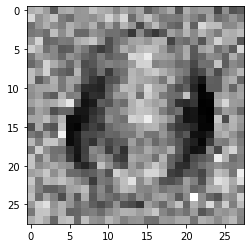

epoch= 1 	 time= 0.04133305549621582 min 	 lr= 0.0002 	 loss_d= 0.9360552549362182 	 loss_g= 1.2709274023771286
epoch= 2 	 time= 0.06326940854390463 min 	 lr= 0.0002 	 loss_d= 0.8699870321154595 	 loss_g= 1.4041507869958878
epoch= 3 	 time= 0.08727567195892334 min 	 lr= 0.0002 	 loss_d= 0.8055453377962113 	 loss_g= 1.5339633613824843
epoch= 4 	 time= 0.10667802095413208 min 	 lr= 0.0002 	 loss_d= 0.7747124925255775 	 loss_g= 1.6210095381736755
epoch= 5 	 time= 0.12622832059860228 min 	 lr= 0.0002 	 loss_d= 0.7492579701542854 	 loss_g= 1.7128921061754228


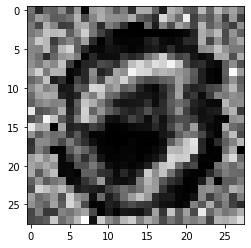

epoch= 6 	 time= 0.1473564624786377 min 	 lr= 0.0002 	 loss_d= 0.7291045364737511 	 loss_g= 1.7737598735094071
epoch= 7 	 time= 0.16657036145528156 min 	 lr= 0.0002 	 loss_d= 0.6952024629712105 	 loss_g= 1.848343043923378
epoch= 8 	 time= 0.18605441649754842 min 	 lr= 0.0002 	 loss_d= 0.6921622958779335 	 loss_g= 1.900682755112648
epoch= 9 	 time= 0.20528153975804647 min 	 lr= 0.0002 	 loss_d= 0.6875612278282642 	 loss_g= 1.9459860992431641
epoch= 10 	 time= 0.22465362151463827 min 	 lr= 0.0002 	 loss_d= 0.6695091731846332 	 loss_g= 1.9706204599142074


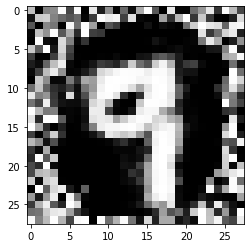

epoch= 11 	 time= 0.24560082356135052 min 	 lr= 0.0002 	 loss_d= 0.6637926955521106 	 loss_g= 2.0037069654464723
epoch= 12 	 time= 0.2649390419324239 min 	 lr= 0.0002 	 loss_d= 0.6575304165482521 	 loss_g= 2.0235256761312486
epoch= 13 	 time= 0.28416507244110106 min 	 lr= 0.0002 	 loss_d= 0.6396766218543053 	 loss_g= 2.085316200852394
epoch= 14 	 time= 0.3036419073740641 min 	 lr= 0.0002 	 loss_d= 0.6364680583775043 	 loss_g= 2.079324131011963
epoch= 15 	 time= 0.3230607708295186 min 	 lr= 0.0002 	 loss_d= 0.6499666672945023 	 loss_g= 2.0892070859670637


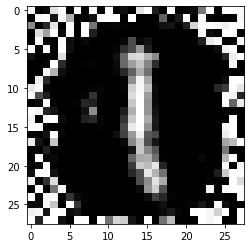

epoch= 16 	 time= 0.3440635164578756 min 	 lr= 0.0002 	 loss_d= 0.6345140974223614 	 loss_g= 2.1313384068012238
epoch= 17 	 time= 0.36330772638320924 min 	 lr= 0.0002 	 loss_d= 0.6308179987967014 	 loss_g= 2.124597162604332
epoch= 18 	 time= 0.3825864712397257 min 	 lr= 0.0002 	 loss_d= 0.6244473858177662 	 loss_g= 2.15209119617939
epoch= 19 	 time= 0.4021639585494995 min 	 lr= 0.0002 	 loss_d= 0.6383579148352146 	 loss_g= 2.152422804236412
epoch= 20 	 time= 0.42186128298441566 min 	 lr= 0.0002 	 loss_d= 0.6555593556165695 	 loss_g= 2.144014548063278


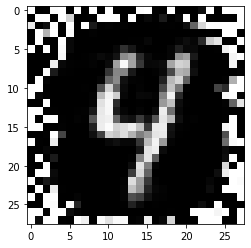

epoch= 21 	 time= 0.4431845903396606 min 	 lr= 0.0002 	 loss_d= 0.6152138248085975 	 loss_g= 2.1995382785797117
epoch= 22 	 time= 0.46279698610305786 min 	 lr= 0.0002 	 loss_d= 0.6397284992039204 	 loss_g= 2.2000142806768417
epoch= 23 	 time= 0.4824754317601522 min 	 lr= 0.0002 	 loss_d= 0.6146468439698219 	 loss_g= 2.2373180216550828
epoch= 24 	 time= 0.5019967079162597 min 	 lr= 0.0002 	 loss_d= 0.5915049880743026 	 loss_g= 2.271035698056221
epoch= 25 	 time= 0.5215436855951945 min 	 lr= 0.0002 	 loss_d= 0.5906874151527881 	 loss_g= 2.316835424900055


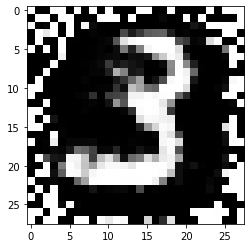

epoch= 26 	 time= 0.5437455852826436 min 	 lr= 0.0002 	 loss_d= 0.6307828223705292 	 loss_g= 2.276656350493431
epoch= 27 	 time= 0.5637928446133932 min 	 lr= 0.0002 	 loss_d= 0.6057146695256234 	 loss_g= 2.285575181245804
epoch= 28 	 time= 0.5832698305447896 min 	 lr= 0.0002 	 loss_d= 0.5959120126068592 	 loss_g= 2.3426928997039793
epoch= 29 	 time= 0.6027751525243124 min 	 lr= 0.0002 	 loss_d= 0.595616330653429 	 loss_g= 2.3599604165554044
epoch= 30 	 time= 0.6221532066663106 min 	 lr= 0.0002 	 loss_d= 0.6053088030219078 	 loss_g= 2.364418647289276


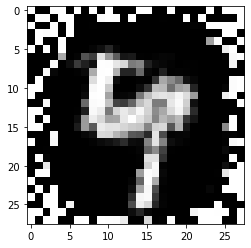

epoch= 31 	 time= 0.6443872968355815 min 	 lr= 0.0002 	 loss_d= 0.6050076854228973 	 loss_g= 2.3838827192783354
epoch= 32 	 time= 0.6638312101364136 min 	 lr= 0.0002 	 loss_d= 0.5935745784640312 	 loss_g= 2.376271984577179
epoch= 33 	 time= 0.6833830038706462 min 	 lr= 0.0002 	 loss_d= 0.5832386568188668 	 loss_g= 2.404179728627205
epoch= 34 	 time= 0.70281449953715 min 	 lr= 0.0002 	 loss_d= 0.593013866096735 	 loss_g= 2.420507486462593
epoch= 35 	 time= 0.7220920642217 min 	 lr= 0.0002 	 loss_d= 0.6027263318002224 	 loss_g= 2.4137813729047775


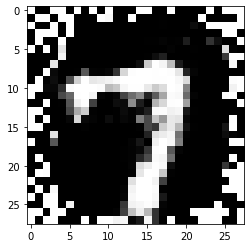

epoch= 36 	 time= 0.7432487567265829 min 	 lr= 0.0002 	 loss_d= 0.5820366695523262 	 loss_g= 2.4267064833641054
epoch= 37 	 time= 0.7626528024673462 min 	 lr= 0.0002 	 loss_d= 0.5671242278814316 	 loss_g= 2.480674557685852
epoch= 38 	 time= 0.7821937362353008 min 	 lr= 0.0002 	 loss_d= 0.5719616529345513 	 loss_g= 2.485878928899765
epoch= 39 	 time= 0.8014114220937093 min 	 lr= 0.0002 	 loss_d= 0.6019588442146778 	 loss_g= 2.4578249728679658
epoch= 40 	 time= 0.8208856066068013 min 	 lr= 0.0002 	 loss_d= 0.5698641242086887 	 loss_g= 2.491442962884903


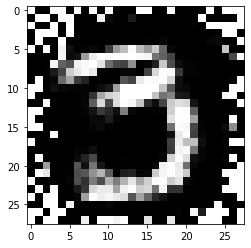

epoch= 41 	 time= 0.8420351982116699 min 	 lr= 0.0002 	 loss_d= 0.5572511756420135 	 loss_g= 2.522846100330353
epoch= 42 	 time= 0.8614899317423502 min 	 lr= 0.0002 	 loss_d= 0.5575051939487458 	 loss_g= 2.5525237107276917
epoch= 43 	 time= 0.8810112396876018 min 	 lr= 0.0002 	 loss_d= 0.5817502711713314 	 loss_g= 2.50410340487957
epoch= 44 	 time= 0.9006279190381368 min 	 lr= 0.0002 	 loss_d= 0.6095448836684227 	 loss_g= 2.487128822803497
epoch= 45 	 time= 0.9202041506767273 min 	 lr= 0.0002 	 loss_d= 0.5795233215391636 	 loss_g= 2.504805451631546


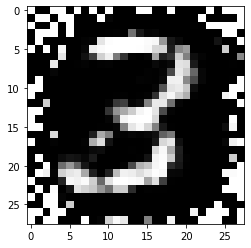

epoch= 46 	 time= 0.9414437333742778 min 	 lr= 0.0002 	 loss_d= 0.5561741858720779 	 loss_g= 2.568603481054306
epoch= 47 	 time= 0.9607898155848186 min 	 lr= 0.0002 	 loss_d= 0.5565720193088055 	 loss_g= 2.567321105003357
epoch= 48 	 time= 0.980332863330841 min 	 lr= 0.0002 	 loss_d= 0.5475029899179935 	 loss_g= 2.5779570758342745
epoch= 49 	 time= 1.0001175999641418 min 	 lr= 0.0002 	 loss_d= 0.5571231172978878 	 loss_g= 2.6062092447280882


In [9]:
# Training loop
net_g = generator()
net_g = net_g.to(device)
print(net_g)
utils.display_num_param(net_g) 
net_d = discriminator()
net_d = net_d.to(device)
print(net_d)
utils.display_num_param(net_d) 

# Optimizer
init_lr = 0.0002
optimizer_g = torch.optim.Adam(net_g.parameters(), lr=init_lr, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(net_d.parameters(), lr=init_lr, betas=(0.5, 0.999))

nb_batch = 200 # GPU # Nb of mini-batches per epoch
#nb_batch = 20 # CPU # Nb of mini-batches per epoch
b = 64  # Batch size

start=time.time()
for epoch in range(50):

    label_real = torch.ones(b, 1)
    label_fake = torch.zeros(b, 1)
    label_real = label_real.to(device)
    label_fake = label_fake.to(device)

    running_loss_d = 0.0
    running_loss_g = 0.0
    num_batches = 0
    
    for _ in range(nb_batch):
        
        # FORWARD AND BACKWARD PASS
        idx = torch.LongTensor(b).random_(0,60000)
        x = train_data[idx,:,:].view(b,-1) # [b, n**2]
        x = x.to(device)
        z = torch.rand(b, dz) # Uniform distribution # [b, dz]
        z = z.to(device)
        
        # update d
        optimizer_d.zero_grad()
        g_z = net_g(z) # [b, 1, n, n]
        d_real = net_d(x.view(-1,n,n).unsqueeze(1)) # [b, 1]
        g_fake = net_d(g_z) # [b, 1]
        loss_real = nn.BCELoss()(d_real, label_real)
        loss_fake = nn.BCELoss()(g_fake, label_fake)
        loss = loss_real + loss_fake
        loss_d = loss.detach().item()
        loss.backward()
        optimizer_d.step()    
        
        # update g
        optimizer_g.zero_grad()
        g_z = net_g(z) # [b, 1, n, n]
        g_fake = net_d(g_z) # [b, 1]
        loss_fake = nn.BCELoss()(g_fake, label_real)
        loss = loss_fake
        loss_g = loss.detach().item()
        loss.backward()
        optimizer_g.step() 

        # COMPUTE STATS
        running_loss_d += loss_d
        running_loss_g += loss_g
        num_batches += 1        
    
    # AVERAGE STATS THEN DISPLAY
    total_loss_d = running_loss_d/ num_batches
    total_loss_g = running_loss_g/ num_batches
    elapsed = (time.time()-start)/60
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', init_lr  ,'\t loss_d=', total_loss_d ,'\t loss_g=', total_loss_g )

    if not epoch%5:
        plt.imshow(g_z.view(b,n,n).detach().cpu()[0,:,:], cmap='gray'); plt.show() 
    

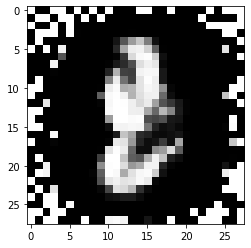

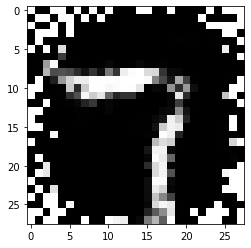

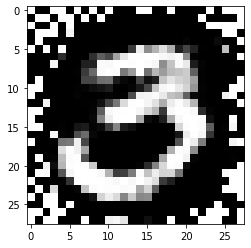

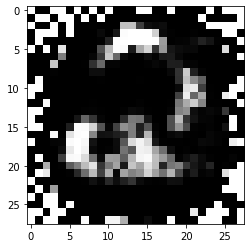

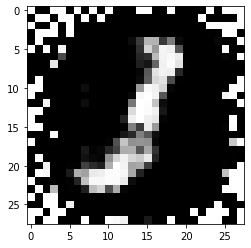

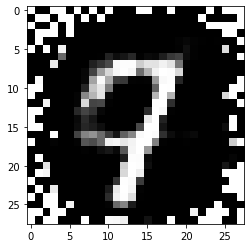

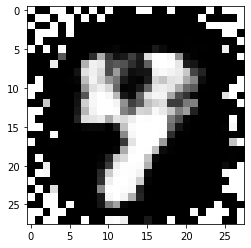

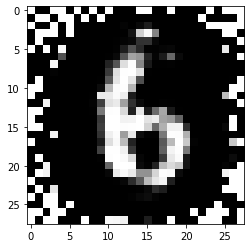

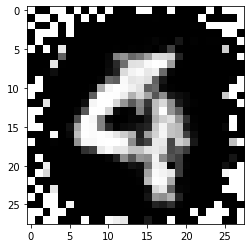

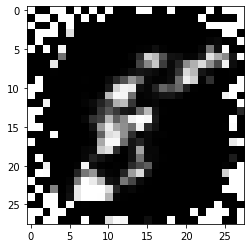

In [10]:
# Generate a few images
b = 10
z = torch.rand(b, dz) # Uniform distribution 
z = z.to(device)
g_z = net_g(z).view(b,n,n).detach().cpu()
for k in range(b):
    plt.imshow(g_z[k,:,:], cmap='gray'); plt.show() 
  